In [25]:

import torch_geometric as pyg
import src.data_transform
import importlib
importlib.reload(src.cgvae.data_transform)
from src.data_transform import get_data
import src.model.baseline
importlib.reload(src.cgvae.baseline)
import  src.model
importlib.reload(src.cgvae)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<module 'src.cgvae.data_transform' from '/Users/cgu3/Documents/conditional-graph-variational-autoencoder/src/cgvae/data_transform.py'>

<module 'src.cgvae.baseline' from '/Users/cgu3/Documents/conditional-graph-variational-autoencoder/src/cgvae/baseline.py'>

<module 'src.cgvae' from '/Users/cgu3/Documents/conditional-graph-variational-autoencoder/src/cgvae/__init__.py'>

In [26]:
%cd /Users/cgu3/Documents/conditional-graph-variational-autoencoder

/Users/cgu3/Documents/conditional-graph-variational-autoencoder


In [27]:
# open ipython terminal
%qtconsole

In [28]:
SPLIT_RATIO = 0.5
dataloader, dataset_size = get_data('../data', 'KarateClub', mask_ratio=0.5, neg_edge_ratio=1.0)
# dataloader, dataset_size = get_data('../data', 'Cora', ratio=SPLIT_RATIO,  random_seed=0)

In [29]:
data = next(iter(dataloader))

In [30]:
dim = data['input'].x.shape[0]
split = int(dim * SPLIT_RATIO)

In [31]:
# create graph from edge_index
import networkx as nx
input_graph = pyg.utils.to_networkx(data['input'])
output_graph = pyg.utils.to_networkx(data['output'])

In [11]:
path = dict(nx.shortest_path_length(input_graph))

In [32]:
# add edge between A and B if the distance between A and B is less than 3 with probability 0.5

expanded_input_graph = input_graph

for i in range(dim):
    for j in range(dim):
        # if  key-pair exists
        if path.get(i) is not None and path[i].get(j) is not None:
            if i != j and path[i][j]  == 2:
                # if np.random.rand() < 0.1:
                    expanded_input_graph.add_edge(i, j)
            
            if i != j and path[i][j] == 3:
                # if np.random.rand() < 0.01:
                    expanded_input_graph.add_edge(i, j)

# make sure the graph is undirected
expanded_input_graph = expanded_input_graph.to_undirected()

In [33]:
# plot the graph adjacency matrix


<Figure size 1000x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Output Adjacency Matrix')

<Axes: >

Text(0.5, 1.0, 'Combined Adjacency Matrix')

<Axes: >

Text(0.5, 1.0, 'Expanded Input Adjacency Matrix')

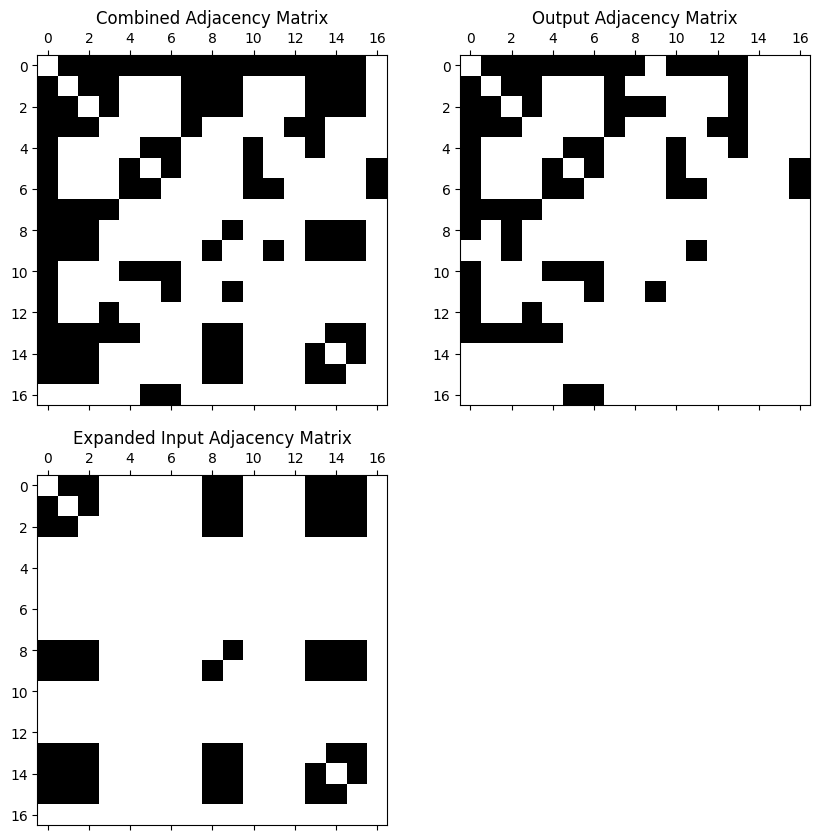

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the adjacency matrices to dense format
expanded_input_adj_matrix_dense = np.array(nx.adjacency_matrix(expanded_input_graph).todense())
output_adjacency_matrix_dense = np.array(nx.adjacency_matrix(output_graph).todense())

# Create a combined adjacency matrix
combined_adj_matrix = expanded_input_adj_matrix_dense + output_adjacency_matrix_dense

# Reassign value 1 if the value is greater than 1
combined_adj_matrix[combined_adj_matrix > 1] = 1

# Create a new figure
plt.figure(figsize=(10, 10))

# Plot the output adjacency matrix
plt.subplot(2, 2, 2)
plt.title('Output Adjacency Matrix')
plt.matshow(output_adjacency_matrix_dense[:split, :split], cmap='Greys', fignum=False)

# Plot the combined adjacency matrix
plt.subplot(2, 2, 1)
plt.title('Combined Adjacency Matrix')
plt.matshow(combined_adj_matrix[:split, :split], cmap='Greys', fignum=False)

plt.subplot(2, 2, 3)
plt.title('Expanded Input Adjacency Matrix')
plt.matshow(expanded_input_adj_matrix_dense[:split, :split],  cmap='Greys', fignum=False)

# Display the plots
plt.show()

In [35]:
# calculate proportions of values in the output adjacency matrix that are 1
np.sum(output_adjacency_matrix_dense[:split, :split] == 1)
np.sum(expanded_input_adj_matrix_dense[:split, :split] == 1)

output_adjacency_matrix_dense_split = output_adjacency_matrix_dense[:split, :split]
expanded_input_adj_matrix_dense_split = expanded_input_adj_matrix_dense[:split, :split]
# a significant portion of direct connetions are also in indirect connections within 3 hops
np.mean(output_adjacency_matrix_dense_split[np.where(output_adjacency_matrix_dense_split == 1)] == expanded_input_adj_matrix_dense_split[np.where(output_adjacency_matrix_dense_split == 1)])

70

56

0.2571428571428571

In [36]:
# # remove standalone pixels
# from scipy import ndimage
# erosion = ndimage.binary_erosion(expanded_input_adj_matrix_dense[:split, :split], structure=np.eye(2)).astype(int)
# plt.matshow(erosion, cmap='Greys')

In [37]:
# get length of the adjacency matrix
combined_adj_matrix = combined_adj_matrix
dim = combined_adj_matrix.shape[0]
mask = np.ones((dim, dim), dtype=bool)
mask[:  int(dim / 2) ,:int(dim  /2)] = 0
combined_adj_matrix[mask] = 0

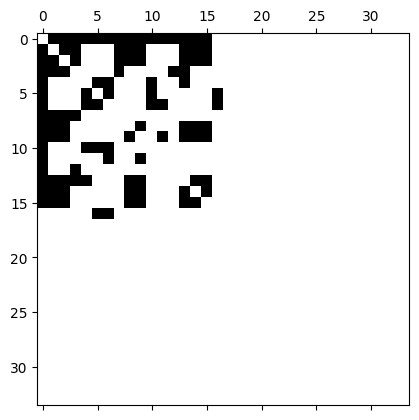

In [38]:
plt.matshow(combined_adj_matrix, cmap='Greys')

In [39]:
# get the input adjacency matrix
input_graph = pyg.utils.to_networkx(data['input'])
input_adj_matrix = nx.adjacency_matrix(input_graph)

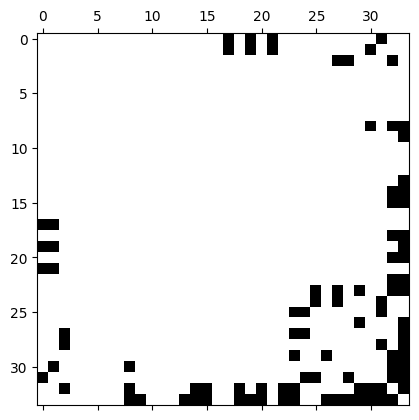

In [40]:
plt.matshow(input_adj_matrix.todense(), cmap='Greys')

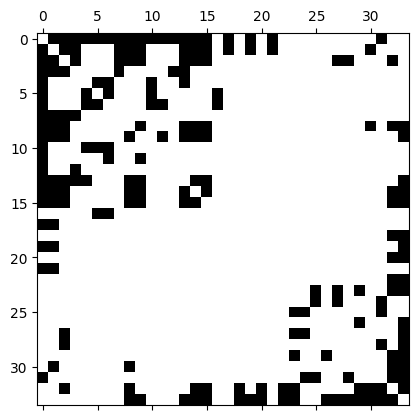

In [41]:
input_combined_adj_matrix = combined_adj_matrix + input_adj_matrix.todense()
plt.matshow(input_combined_adj_matrix, cmap='Greys')

In [42]:
# generate permutation matrix
np.random.seed(0)
perm = np.eye(dim, dtype=int)
np.random.shuffle(perm)

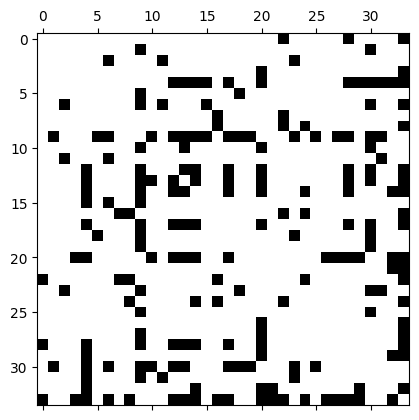

In [43]:
# use permutation matrix to shuffle the adjacency matrix input_combined_adj_matrix
shuffled_combined_adj_matrix = perm @ input_combined_adj_matrix @ perm.T
plt.matshow(shuffled_combined_adj_matrix, cmap='Greys')

In [44]:
# todo: how to regularize the total number of edges in the adjacency matrix

random sample from multivariate norm and connect nodes based on similarity
then random remove links in a subgraph, for removed links add random noise for nodes in two sides 